In [ ]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import lightgbm as lgb
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

In [207]:
import os, contextlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 30)

In [ ]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [134]:
train = pd.read_csv('../data/preproc4_train.csv').drop(['Time', 'Solar radiation'], axis=1)

xgb_params = pd.read_csv('../xgboost/hyperparameter_xgb_final.csv')

xgb_models = []
pred_df_list = []
preds = np.array([]) 
for i in tqdm(range(100)):
    
    models = []
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    params = xgb_params.iloc[i, :]

    for seed in range(6): # 각 시드별 예측
        y_train = train.loc[train.building_id == i+1, 'consumption']
        x_train = train.loc[train.building_id == i+1, ].drop(['building_id', 'consumption'], axis=1)

        xgb = XGBRegressor(seed = seed,
                        n_estimators = int(params['n_estimators']),
                        eta = 0.01,
                        min_child_weight = params['min_child_weight'],
                        max_depth = int(params['max_depth']),
                        colsample_bytree = params['colsample_bytree'],
                        subsample = params['subsample'],
                        # tree_method = 'gpu_hist',
                        # predictor= 'gpu_predictor'
                        )
    
        # if params['alpha'] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
        #     xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_train)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        models.append(xgb)
    xgb_models.append(models)

    pred_df_list.append(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

1.6492699642103228
1.6459570903327705
1.6427738573908996
1.6623566657246176
1.6653507971961805
1.6450706204846042
3.1187707003484464
3.068531774458004
3.063792616306023
3.069415621648608
3.0480823313436383
3.0809719463653367
4.751995043675016
4.751995043675016
4.751995043675016
4.751995043675016
4.751995043675016
4.751995043675016
1.6643261161602345
1.6978370459619994
1.6794621083122214
1.6961984283158316
1.6751665072072128
1.6981447321545304
2.1960521990773367
2.1960521990773367
2.1960521990773367
2.1960521990773367
2.1960521990773367
2.1960521990773367
1.3767873087313098
1.3767873087313098
1.3767873087313098
1.3767873087313098
1.3767873087313098
1.3767873087313098
2.358533836984555
2.330631008143801
2.3641928017262073
2.3446847342125494
2.334567353885332
2.3449215437550066
1.6299840311024743
1.6270548401575737
1.6162561783137432
1.6413768091908965
1.6206490465452041
1.6140868810183844
1.3463794048368136
1.3221547465201238
1.2979280380022344
1.3061511761182558
1.3524813369140403
1.316

In [116]:
lgbm_params = pd.read_csv('../lgbm/hyperparameter_xgb_final.csv')

train = pd.read_csv('../data/preproc3_train.csv').drop(['Time', 'Solar radiation'], axis=1)


lgbm_models = []
lgbm_pred_df_list = []
preds = np.array([])

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    for i in tqdm(range(100)):
        
        models = []
        
        pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
        params = lgbm_params.iloc[i, :]

        for seed in range(6): # 각 시드별 예측
            y_train = train.loc[train.building_id == i+1, 'consumption']
            x_train = train.loc[train.building_id == i+1, ].drop(['building_id', 'consumption'], axis=1)

            lgbm = LGBMRegressor(seed = 0,
                            n_estimators = int(params['best_iter']),
                            eta = 0.01,
                            min_child_weight = params['min_child_weight'],
                            max_depth = int(params['max_depth']),
                            colsample_bytree = params['colsample_bytree'],
                            subsample = params['subsample'],
                            #   reg_alpha = params['reg_alpha'],
                            #   reg_lambda = params['reg_lambda'],
                            tree_method = 'gpu_hist',
                            predictor= 'gpu_predictor')
        
            if params['alpha'] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
                lgbm.set_params(**{'objective':weighted_mse(lgbm_params.iloc[i,6])})
            
            lgbm.fit(x_train, y_train)
            y_pred = lgbm.predict(x_train)
            pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기

            models.append(lgbm)
        lgbm_models.append(models)

        lgbm_pred_df_list.append(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [203]:
x

,0,1,2,3,4,5
0,974.408875,974.737488,976.072327,974.669434,971.247681,972.160522
1,972.435791,974.729797,974.996399,974.145874,973.514832,972.359375
2,968.307190,970.356812,970.296936,967.637329,972.951782,968.281128
3,985.850952,977.575378,977.442444,975.984741,976.353271,975.655029
4,972.658691,970.147705,971.262756,971.521973,966.553345,971.934570
...,...,...,...,...,...,...
2035,1186.804932,1198.895630,1194.004761,1193.892822,1195.992065,1196.152954
2036,1112.680908,1111.259155,1108.303345,1112.328857,1114.253784,1112.891113
2037,1103.282227,1102.856079,1099.270630,1102.900757,1105.551636,1102.431885
2038,1083.770630,1086.080933,1082.181152,1086.998047,1087.682983,1083.502319


In [204]:
y

44880     987.6
44881     988.5
44882     982.8
44883     985.8
44884     987.3
          ...  
46915    1198.8
46916    1152.0
46917    1133.4
46918    1097.1
46919    1078.2
Name: consumption, Length: 2040, dtype: float64

In [228]:
from sklearn.linear_model import Lasso

ensemble_models = []
scores = []
ensembles = []

is_ensemble = True
is_mean = False

for i in range(100):
    ensemble = AdaBoostRegressor(n_estimators=100, random_state=0,
                            base_estimator=Lasso(max_iter=100),
                            )
    # ensemble = Ridge()
    y = train.loc[train.building_id == i+1, 'consumption']
    # x = pd.concat([pred_df_list[i], lgbm_pred_df_list[i]], axis=1)
    x = pred_df_list[i]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    ensemble.fit(x_train, y_train)
    ensemble_models.append(ensemble)
    ensemble_pred = ensemble.predict(x_valid)
    ensemble_score = SMAPE(y_valid, ensemble_pred)

    mean_pred = np.array(np.mean(x_valid, axis = 1))
    mean_score = SMAPE(y_valid, mean_pred)

    if is_ensemble and not is_mean:
        score = ensemble_score
        ensembles.append('ensemble')
    elif is_mean and not is_ada:
        score = mean_score
        ensembles.append('mean')
    elif ada_score <= mean_score:
            score = ada_score
            ensembles.append('ensemble')
    elif ada_score > mean_score:
        score = mean_score
        ensembles.append('mean')
        
    scores.append(score)
    print(f"Biulding {i + 1} SMAPE: {score}, mean: {mean_score}, Best is {ensembles[i]}")

Biulding 1 SMAPE: 1.5112916427073928, mean: 1.5112416285001322, Best is ensemble
Biulding 2 SMAPE: 3.4905615334303115, mean: 3.04005810442643, Best is ensemble
Biulding 3 SMAPE: 5.100567887907497, mean: 5.212538383549268, Best is ensemble
Biulding 4 SMAPE: 1.446789689174535, mean: 1.4975542858707998, Best is ensemble
Biulding 5 SMAPE: 1.9645232082144957, mean: 1.847841688243232, Best is ensemble
Biulding 6 SMAPE: 1.358419936416189, mean: 1.3108435723329561, Best is ensemble
Biulding 7 SMAPE: 2.4910555717415646, mean: 2.589319879068212, Best is ensemble
Biulding 8 SMAPE: 1.4921205577737642, mean: 1.5186003994551918, Best is ensemble
Biulding 9 SMAPE: 1.0674107893716953, mean: 0.9898512046650225, Best is ensemble
Biulding 10 SMAPE: 2.122370173714062, mean: 2.128610590836533, Best is ensemble
Biulding 11 SMAPE: 0.9068818793694036, mean: 0.8698793841467893, Best is ensemble
Biulding 12 SMAPE: 1.1375654368997563, mean: 1.1179992169950905, Best is ensemble
Biulding 13 SMAPE: 1.26027531014676

Max: 10.323510257992764, Mean: 1.911921997663349


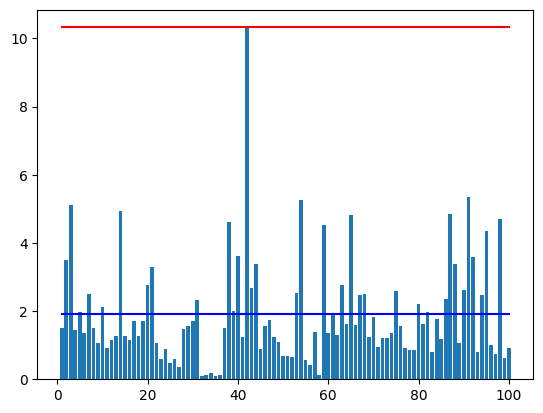

In [229]:
no_df = pd.DataFrame({'score':scores})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
max_score = max(no_df['score'])
plt.plot([1,100], [max_score, max_score], color = 'red')
mean_score = np.mean(no_df['score'])
plt.plot([1,100], [mean_score, mean_score], color = 'b')

print(f"Max: {max_score}, Mean: {mean_score}")

In [230]:
test = pd.read_csv('../data/preproc4_test.csv')
test = test.drop(['Time'], axis=1)

test2 = pd.read_csv('../data/preproc3_test.csv')
test2 = test2.drop(['Time', 'type', 'cluster'], axis=1)

pred_test_df_list = []
ensemble_preds = []

for i in range(100):
    x_test = test.loc[test.building_id == i+1, ].drop(['building_id'], axis=1)
    x_test2 = test2.loc[test.building_id == i+1, ].drop(['building_id'], axis=1)

    xgb_model = xgb_models[i]
    lgbm_model = lgbm_models[i]
    ensemble = ensemble_models[i]
    is_ensemble = ensembles[i]

    xgb_pred_test_df = pd.DataFrame()
    lgbm_pred_test_df = pd.DataFrame()

    for seed in range(6):
        xgb = xgb_model[seed]
        lgbm = lgbm_model[seed]
        xgb_y_pred = xgb.predict(x_test)
        lgbm_y_pred = lgbm.predict(x_test2)

        xgb_pred_test_df.loc[:,seed] = xgb_y_pred
        lgbm_pred_test_df.loc[:,seed] = lgbm_y_pred
    
    # pred_test_df = pd.concat([xgb_pred_test_df, lgbm_pred_test_df], axis=1)
    pred_test_df = xgb_pred_test_df
    pred_test_df_list.append(pred_test_df)

    if is_ensemble == 'ensemble':
        ensemble_pred = ensemble.predict(pred_test_df)
    else:
        ensemble_pred = np.array(np.mean(pred_test_df, axis = 1))

    ensemble_preds.extend(ensemble_pred)

[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ig

In [231]:
submission = pd.read_csv('../data/sample_submission.csv')
submission['answer'] = ensemble_preds
submission.to_csv('../data/submission/submission_ridge_xgb.csv', index = False)

In [131]:
pd.read_csv('../data/submission/submission_ada_lgbm.csv')

,num_date_time,answer
0,1_20220825 00,1975.111146
1,1_20220825 01,1821.214632
2,1_20220825 02,1738.195385
3,1_20220825 03,1673.682439
4,1_20220825 04,1655.323975
...,...,...
16795,100_20220831 19,862.341582
16796,100_20220831 20,717.255711
16797,100_20220831 21,641.594163
16798,100_20220831 22,532.016890
